In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [57]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
# index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
# index

In [58]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [60]:
rolling_window = 100
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2025
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["year"]>=model_end) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["dividend"] = 0
            for member in Indicator:
                price  = member.calculate(price,timeframe=rolling_window,live=False)
            for member in Metric:
                price  = member.calculate(price,timeframe=rolling_window,live=False)
            for member in RiskType:
                price  = member.apply(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  6%|█████████                                                                                                                                                       | 638/11273 [00:30<07:26, 23.82it/s]

index 0 is out of bounds for axis 0 with size 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11273/11273 [08:33<00:00, 21.96it/s]


In [61]:
simulation = pd.concat(prices)
simulation.sort_values("date", inplace=True)

In [62]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                member.label for member in Indicator
                                                            ]
                                                            ,num_of_groups=[3,5,10]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[np.inf]
                                                            ,max_market_caps=[np.inf]
                                                            ,min_market_caps=[0]
                                                            ,min_prices=[0]
                                                            ,stoplosses=[0.1]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.position_type.label == "long" and "blacklist" not in portfolio.selection_type.label and portfolio.ranking_metric != "optimal" and portfolio.timeframe.value != "day":
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

2016

In [63]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2016/2016 [5:35:23<00:00,  9.98s/it]


In [64]:
a = pd.DataFrame(analysises)

In [91]:
metric = "raw_pnl"
dropped_columns = ["date","selection_percentage","stoploss","max_price","min_price","max_market_cap","min_market_cap","leverage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,num_of_groups,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio,color,return_to_risk
997,roc,WEEK,long,DISTANCE,bottom,equal,coefficient_of_variation,5,1.077807,1.077592e+06,0.998466,40.229320,0.026792,-18.418443,0.218840,-2.254889,red,40.229320
537,bollinger_upper,WEEK,long,STANDARD_DEV,top,risk,coefficient_of_variation,3,1.062701,7.529027e+05,0.998568,46.933108,0.022643,-22.460271,0.222784,-2.282775,blue,46.933108
996,roc,WEEK,long,DISTANCE,bottom,equal,coefficient_of_variation,3,1.075439,3.095172e+05,0.998163,41.784024,0.025738,-19.264362,0.219839,-2.255410,red,41.784024
249,sma,WEEK,long,STANDARD_DEV,top,risk,coefficient_of_variation,3,1.054951,3.086974e+05,0.998520,54.882995,0.019222,-26.860902,0.226007,-2.284506,blue,54.882995
672,bollinger_lower,WEEK,long,STANDARD_DEV,mixed,equal,coefficient_of_variation,3,1.031233,2.927398e+05,0.998944,80.848967,0.012755,-42.338731,0.230284,-2.345077,green,80.848967
534,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,3,1.054104,2.028384e+05,0.998642,52.159545,0.020209,-25.590397,0.224274,-2.305943,blue,52.159545
972,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,3,1.058213,7.280205e+04,0.997900,47.391491,0.022329,-22.976797,0.223927,-2.291166,red,47.391491
246,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,3,1.046366,5.597193e+04,0.998616,61.022147,0.017147,-30.611175,0.227746,-2.304758,blue,61.022147
678,bollinger_lower,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,3,1.029365,4.587694e+04,0.998216,80.925026,0.012720,-42.602290,0.230540,-2.350571,blue,80.925026
639,bollinger_lower,MONTH,long,STANDARD_DEV,bottom,risk,coefficient_of_variation,3,1.032503,4.248707e+04,0.997742,84.138997,0.012271,-53.335439,0.260569,-2.511814,red,84.138997


In [92]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [85]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

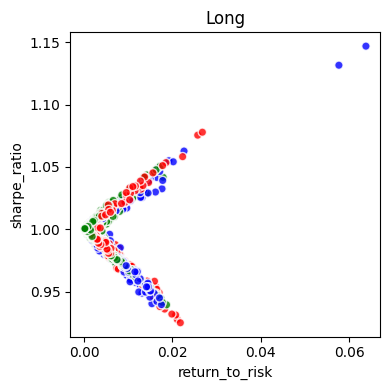

In [86]:
# Filter data for long positions
d_analysis = a[a["position_type"] == "long"]

# Create a single scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(
    d_analysis["portfolio_std"],
    d_analysis["pnl"],
    c=d_analysis["color"],
    alpha=0.8,
    edgecolors="w"
)
plt.title("Long")
plt.xlabel("return_to_risk")
plt.ylabel("sharpe_ratio")
plt.tight_layout()
plt.show()

In [87]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

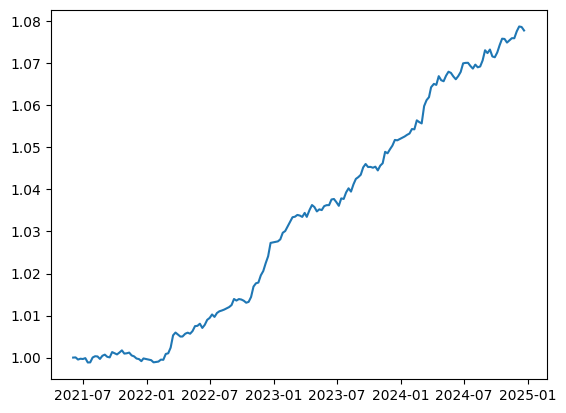

In [88]:
plt.plot(portfolio["date"],portfolio["pnl"])
plt.show()

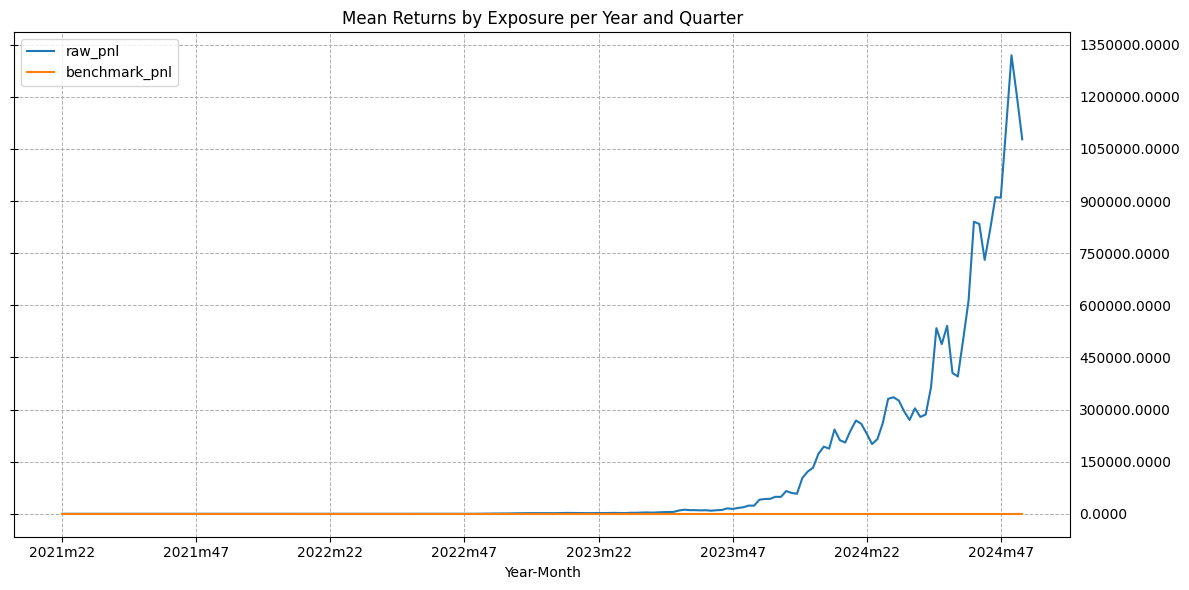

In [89]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()